In [1]:
!pip install records boto3 psycopg2-binary pandas

Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 6, in <module>
    sys.exit(pip.main())
AttributeError: module 'pip' has no attribute 'main'


In [1]:
import boto3
import records
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [2]:
db_url = boto3.client('ssm').get_parameter(Name='/bikefinder/dev/db_url', WithDecryption=True)['Parameter']['Value']
db = records.Database(db_url)

In [3]:
# number of bikes in operaton per day per provider
bikes_in_service = db.query(
    """
    ( -- number of unique bike_ids per provider (except ofo)
      select created::date, provider, count(distinct bike_id) num_bikes
      from bike_locations
      where provider<>'ofo'
      group by provider, created::date
    )
    union
    ( -- max number of ofo bikes available through out the day
      with ofo as (select * from bike_locations where provider='ofo'),
        counts_per_batch as (select count(bike_id), bike_id, created::date from ofo
                             group by bike_id, created::date)
      select created, 'ofo' provider, max("count") num_bikes
      from counts_per_batch
      group by created
    )
    order by created, provider;
    """).export('df')
bikes_in_service = bikes_in_service.pivot(index='created', columns='provider', values='num_bikes')

In [4]:
bikes_in_service

provider,JUMP,limebike,mobike,ofo,spin
created,,,,,
2018-02-18,54.0,370.0,464.0,338.0,163.0
2018-02-19,57.0,385.0,470.0,337.0,177.0
2018-02-20,68.0,391.0,463.0,330.0,185.0
2018-02-21,75.0,422.0,468.0,295.0,187.0
2018-02-22,190.0,409.0,461.0,350.0,197.0
2018-02-23,123.0,399.0,453.0,343.0,204.0
2018-02-24,69.0,398.0,451.0,323.0,189.0
2018-02-25,72.0,386.0,442.0,312.0,188.0
2018-02-26,84.0,402.0,439.0,337.0,186.0


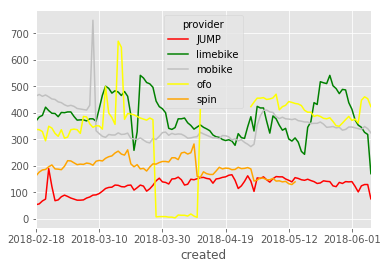

In [5]:
plt = bikes_in_service.plot()
plt.get_lines()[0].set_color('red')
plt.get_legend().get_lines()[0].set_color('red')
plt.get_lines()[1].set_color('green')
plt.get_legend().get_lines()[1].set_color('green')
plt.get_lines()[2].set_color('silver')
plt.get_legend().get_lines()[2].set_color('silver')
plt.get_lines()[3].set_color('yellow')
plt.get_legend().get_lines()[3].set_color('yellow')
plt.get_lines()[4].set_color('orange')
plt.get_legend().get_lines()[4].set_color('orange')

In [6]:
# min,avg,max lifetime of bikes per provider (except ofo, of course)
db.query(
    """
    with bike_lifetimes as (
        select bike_id, provider, max(created) - min(created) age
        from bike_locations
        where provider<>'ofo'
        group by bike_id, provider
    )
    select provider, min(age), avg(age), max(age)
    from bike_lifetimes
    group by provider;
    """).export('df')

,provider,min,avg,max
0,JUMP,0 days,91 days 14:56:30.889278,113 days 02:32:13.754591
1,mobike,0 days,37 days 10:07:51.429577,95 days 04:12:08.992498
2,spin,0 days,37 days 20:43:01.574388,85 days 03:21:50.453325
3,limebike,0 days,28 days 08:09:10.146813,113 days 02:32:27.093548


In [ ]:
db.close()
db._engine.dispose()